## 1. Load the package

In [1]:
# load the package 

import os, shutil
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings('ignore')

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from utils.labels_preprocessing import load_labels
from utils.load_synced_inputs import load_inputs
from utils.load_graphs import load_graph

from cnn_graph.resnetgraph import cgcnn
from cnn_graph import graph

import tensorflow as tf

from matplotlib import pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

## 2. Establish Directories for Data Extraction

In [2]:
home = f"{os.getcwd()}/.."

graphs_dir = f"{home}/Graphs/"            # directory containing necessary graphs

cortical_dir = '.../Data/DL_matrices_hier_HCP/Cortex'   # path for the HCP cortical dataset
subcortical_dir = '.../Data/DL_matrices_hier_HCP/Subcortical'  # path for the HCP subcortical dataset

assert len(os.listdir(cortical_dir)) == len(set(os.listdir(cortical_dir)))

In [3]:
print(len(os.listdir(cortical_dir)))
print(len(os.listdir(subcortical_dir)))

1114
1114


## 3. Load Labels

In [5]:
Path = '.../hcp_data.csv'  #path for the HCP labels
df = pd.read_csv(Path)
df_fluid = df[['Subject','Gender','Age_in_Yrs','CogFluidComp_Unadj','CogFluidComp_AgeAdj']]   # choose the columns you want
df_new = df_fluid.dropna(subset=['CogFluidComp_Unadj'])                                       # drop the Nan rows
df_new.head(8)

,Subject,Gender,Age_in_Yrs,CogFluidComp_Unadj,CogFluidComp_AgeAdj
0,100206,1,27,134.34,130.07
1,100307,0,27,118.16,107.88
2,100408,1,33,116.64,113.77
3,100610,1,27,124.23,115.63
4,101006,0,35,91.44,72.02
5,101107,1,22,117.37,106.57
6,101309,1,29,107.14,90.01
7,101410,1,29,112.21,106.16


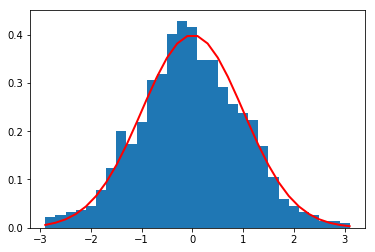

In [12]:
#show the distribution 
s = np.random.normal(0, 1, df_new.shape[0])
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/( np.sqrt(2 * np.pi)) *
                np.exp( - (bins )**2 / (2) ),
          linewidth=2, color='r')
plt.show()

In [13]:
def quantile_normalize_using_target(x, target):
    """
    Both `x` and `target` are numpy arrays of equal lengths.
    """
    target_sorted = np.sort(target)
    return target_sorted[x.argsort().argsort()]

In [14]:
xx = quantile_normalize_using_target(df_new['CogFluidComp_Unadj'].as_matrix(),s)
encoded_labels = xx
print(encoded_labels)

[ 1.50027461  0.25760086  0.13902869 ... -1.40481694 -0.27284455
 -0.95095338]


In [15]:
df_new['CogFluidComp_nor'] = pd.DataFrame({'CogFluidComp_nor': xx})
df_new.head(8)

,Subject,Gender,Age_in_Yrs,CogFluidComp_Unadj,CogFluidComp_AgeAdj,CogFluidComp_nor
0,100206,1,27,134.34,130.07,1.500275
1,100307,0,27,118.16,107.88,0.257601
2,100408,1,33,116.64,113.77,0.139029
3,100610,1,27,124.23,115.63,0.728519
4,101006,0,35,91.44,72.02,-2.506572
5,101107,1,22,117.37,106.57,0.184971
6,101309,1,29,107.14,90.01,-0.631652
7,101410,1,29,112.21,106.16,-0.193428


In [16]:
filenames = df_new['Subject'].astype('str').as_matrix()
filenames2 = ('s' + filenames + '_Cortex.mat').tolist()
# print(filenames2)

## 4. Load Input Data (Cortical & SubCortical)

In [18]:
# construct the graph for cortical and subcortical dataset
graph_type = {'cortical':{'path':cortical_dir, 
                          'parts':['white', 'pial'], 
                          'halves':True},
              
              'subcortical':{'path':subcortical_dir,
                             'parts':'all_sc', 
                             'halves':False}
             }
X = load_inputs(graph_type=graph_type, filenames = filenames2)

sub_graphs = list(graph_type.keys())
assert sub_graphs == ['cortical', 'subcortical']

Cortical	(Samples, Nodes, Feat.):	(1097, 32768, 6)
Subcortical	(Samples, Nodes, Feat.):	(1097, 14848, 3)


## 5. Analyze Distribution of Input Data for Both Surfaces

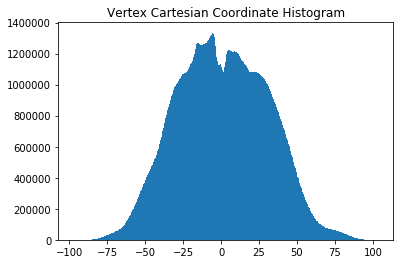

In [19]:
all_nodes = np.concatenate([X[sub].flatten() for sub in sub_graphs])
plt.hist( all_nodes, bins=500) 
plt.title('Vertex Cartesian Coordinate Histogram')
plt.show()

## 6. MinMax Normalize Input Data

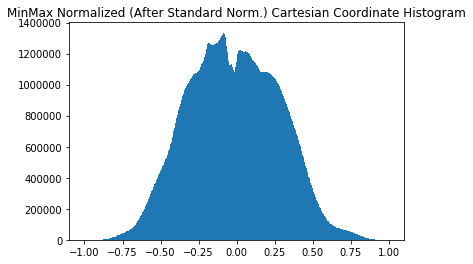

In [20]:
X_max = np.max(all_nodes)
X_min = np.min(all_nodes)

for sub in sub_graphs:
    X[sub] = (X[sub] - X_min) / (X_max - X_min)
    X[sub] *= 2
    X[sub] -= 1
    
all_nodes = np.concatenate([X[sub].flatten() for sub in sub_graphs])
plt.hist( all_nodes, bins=500) 
plt.title('MinMax Normalized (After Standard Norm.) Cartesian Coordinate Histogram')
plt.show()

# del all_nodes

## 7. Block Diagonalize the Cortical Features with the SubCortical Features

In [22]:
from scipy.linalg import block_diag
from sklearn.utils import resample
new_X = []
for A,B in zip(X[f"cortical"], X[f"subcortical"]):
    new_X.append(block_diag(A,B))
X = np.concatenate([np.expand_dims(i, axis=0) for i in new_X], axis=0).astype('float32')
del new_X
print(np.min(X), np.max(X))

-1.0 1.0


## 8. Split the training and validation dataset using Cross-validation

In [23]:
from sklearn.model_selection import KFold
import numpy as np
T2= [i for i in range(182*1, 1097)]
train_index =  T2 
val_index = [j for j in range(182*0, 182*1)]  # you can change it here for cross-validation
# print(train_dex)
# print(len(train_index))
X_train, X_val = X[train_index], X[val_index]
y_train, y_val = encoded_labels[train_index], encoded_labels[val_index]


In [25]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1097, 47616, 9) (1097,) (182, 47616, 9) (182,)


## 9. Load Graph Adjacencies and Convert Into Laplacians

In [26]:
L = {}
L['cortical'] = load_graph(graphs_folder=graphs_dir, prefix='M_w')
L['cortical'] = [graph.laplacian(A) for A in L['cortical']]

L['subcortical'] = load_graph(graphs_folder=graphs_dir, prefix='M_sc_w')
L['subcortical'] = [graph.laplacian(A) for A in L['subcortical']]

## 10. Block Diagonalize the Cortical & Subcortical Laplacians at Each Level of Coarsening

In [27]:
from scipy.sparse import block_diag as sparse_block_diag

In [28]:
new_L = []
for A,B in zip(L[f"cortical"], L[f"subcortical"]):
    new_L.append( sparse_block_diag((A,B)) )
L = new_L
del new_L

In [29]:
np.save('C:/Users/physics/Desktop/Laplacians.npy', L)

In [27]:
np.save('C:/Users/physics/Desktop/Data_all_subjects.npy', X)

In [29]:
np.save('C:/Users/physics/Desktop/labels.npy', encoded_labels)

## 11. ChebyNet Model Parameters Initialization

In [1]:
# Initial training parameters
params = {'num_epochs': 200, 
          'batch_size': 32,
          'eval_frequency': 10
         }

# Expected features dimension sizing of the input
# N_feat = X_train.shape[-1]
N_feat = 9
params.update(task = 'regression')

if N_feat == 1:
    params['V'] = None
elif N_feat > 1:
    params['V'] = N_feat
else:
    raise ValueError('Input features dim. should be >= 1')

# # Network task initialization
# C = np.max(encoded_labels) + 1
# params.update(M = [C]) # number of units in fully-connected layer (set to # classes for classification)  
if params['task'] == 'classification':
    # Number of classes.()
    C = np.max(Gender) + 1
    assert C == np.unique(Gender).size
    params['M']              = [C]  # Set fully connected layer output to the number of class
else:
    arr = [0,0,0]
    C = np.max(arr) + 1    
    params['M']              = [C]

# Network Architecture
params['F']   = [16 for _ in range(4)] # number of filters per layer
params['K']   = 3                      # polynomial order of each layer
params['p']   = 2                      # pooling size per layer
params['B']   = len(params['F'])       # number of ResNet blocks
params['F_l'] = 128                     # number of post-ResNet filters

# Optimization Parameters
params['regularization'] = 0.
params['learning_rate']  = 5e-4
params['decay_rate']     = 0.999
params['momentum']       = 0.
params['dropout']        = 1.          # Using TF 1.13.1 so this is the KEEP PROBABILITY
params['decay_steps']    = 1.

# AUGMENTATION PROB. SET TO ZERO (NO AUGMENTATION)
params.update(prob_augment = 0.)

# Model Saving
params['dir_name'] = f"{home}/models/HCP_CogFluidScore"
# os.mkdir(params['dir_name'])
print(params['dir_name'])

## 12. Create Model

In [98]:
model = cgcnn(L, **params)

NN architecture
  input: M_0 = 47616
 
Pre-convolution layer:
  biases: L_0 * F_0_ = 47616 * 16 = 761856
  weights: V * F_0 * K_0 = 9 * 16 * 3 = 432
 
ResNet blocks:
 Block 0
    batch normalization: 2 * L_0 = 2 * 47616 = 95232
    weights: F_0 * F_0 * K_0 = 16 * 16 * 3 = 768
 Block 1
    batch normalization: 2 * L_1 = 2 * 23808 = 47616
    weights: F_1 * F_1 * K_1 = 16 * 16 * 3 = 768
 Block 2
    batch normalization: 2 * L_2 = 2 * 11904 = 23808
    weights: F_2 * F_2 * K_2 = 16 * 16 * 3 = 768
 Block 3
    batch normalization: 2 * L_3 = 2 * 5952 = 11904
    weights: F_3 * F_3 * K_3 = 16 * 16 * 3 = 768
 
Post-convolution layer:
  batch normalization: 2 * L_3 = 2 * 5952 = 11904
 
Fully connected layer:
  weights: K_3 * M = 3 * 1 = 3
L_post = 2976 ; F_post = 128 ; K_post = 3


## 13. Training

In [9]:
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

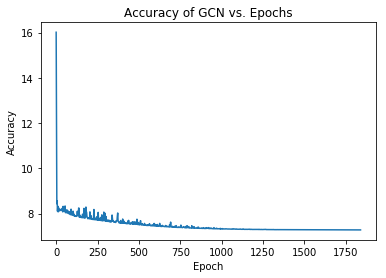

In [37]:
plt.plot(np.arange(0, 921*2,2),accuracy)
plt.title('Accuracy of GCN vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 14. CAM & Testing for each fold after training each fold

In [2]:
a, CAM_map_a = model.predict(X_train[0:183], CAM = True)
np.save('path',CAM_map_a)

In [3]:
b, CAM_map_b = model.predict(X_train[183*1:183*2], CAM = True)
np.save('path',CAM_map_b)

In [4]:
c, CAM_map_c = model.predict(X_train[183*2:183*3], CAM = True)
np.save('path',CAM_map_c)

In [5]:
d, CAM_map_d = model.predict(X_train[183*3:183*4], CAM = True)
np.save('path',CAM_map_d)

In [6]:
e,CAM_map_e = model.predict(X_train[183*4:183*5], CAM = True)
np.save('path',CAM_map_e)

In [7]:
f, CAM_map_f = model.predict(X_train[183*5:183*6], CAM = True)
np.save('path',CAM_map_f)

In [67]:
preds = (a + b +c +d +e + f)/6.0

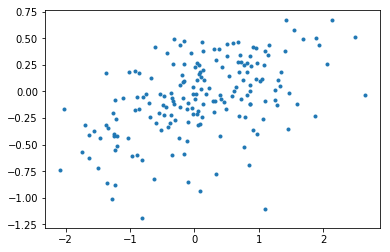

In [35]:
plt.plot(y_val, preds, '.')

In [8]:
# calculate correlation and mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res = r2_score(y_train,pred)
print('r2', res)
from scipy.stats import pearsonr
corr, p_value = pearsonr(y_train,pred)
print('corr', corr, 'p', p_value)

mse = mean_squared_error(y_train,pred)
print('mse', mse)

In [80]:
pred = np.concatenate((a,b,c,d,e,f))
print(pred.shape)

(1097,)


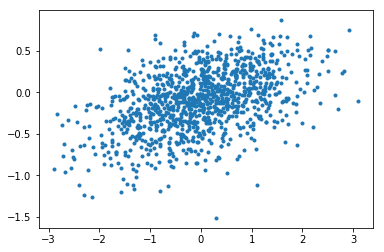

In [81]:
plt.plot(y_train, pred, '.')

0.5494391533271402


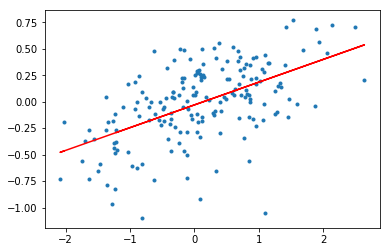

In [73]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(y_val,preds)
plt.plot(y_val, preds, '.')
# x = np.linspace(-2,2)
y = y_val*slope+intercept
plt.plot(y_val, y, 'r')
print(r_value)